---------------

# **<font style="color:Black">Create OCR by PyTorch</font>**
-------------------
-----------------

## **<font style="color:blue">Installation and import libraries</font>**
-------------------

In [1]:
!pip install  pillow 
!pip install opencv-python
!pip install matplotlib

In [2]:
import os
import sys
import shutil
import random
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageFilter
import numpy as np
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

## **<font style="color:blue">Hyperparameters</font>**
-------------------

In [3]:
OUTPUT_DIR = os.path.join('/kaggle','working','synthetic_data','images')
MODEL_DIR = os.path.join('/kaggle','working','model_dir')
LABELS_FILE = os.path.join('/kaggle','working','synthetic_data','labels.txt')
NUM_SAMPLES = 1280  # Number of images generated
IMG_WIDTH = 128
IMG_HEIGHT = 32
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001
CHARSET = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-*"  # Group characters
MAX_TEXT_LENGTH = 10  # Maximum length of text in an image
FONT_DIR = os.path.join('/kaggle','input','google-fonts','GoogleFontScripts') # Folder with TrueType fonts (.ttf)
BACKGROUND_DIR = os.path.join('/kaggle','working','backgrounds')  # New folder for background (optional)
NUMBER_BACKGROUND_IMAGE = 20

## **<font style="color:blue">Utils support functions</font>**
-------------------

### **<font style="color:green">Create output folders</font>**

In [4]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(BACKGROUND_DIR, exist_ok=True)

# Creates a new file
with open(LABELS_FILE, 'w') as fp:
    pass

### **<font style="color:green">Load the font list (add the paths to the .ttf files to the "fonts" folder)</font>**

In [5]:
font_files = [
    os.path.join(FONT_DIR, f) for f in os.listdir(FONT_DIR) 
    if f.endswith('.ttf') and os.path.isfile(os.path.join(FONT_DIR, f))
]
if not font_files:
    raise FileNotFoundError("No fonts found in 'fonts' folder. Add .ttf files!")

### **<font style="color:green">Generating a simple gradient background</font>**

In [6]:
def generate_gradient_background(filename, size=(128, 32)):
    img = Image.new('L', size, color=230)  # Lighter gray as a base
    draw = ImageDraw.Draw(img)
    for y in range(size[1]):
        # Soft gradient with low contrast
        color = int(230 - 20 * (y / size[1]))  # From light gray to slightly darker
        draw.line([(0, y), (size[0], y)], fill=color)
    # Background blur
    img = img.filter(ImageFilter.GaussianBlur(radius=2))
    img.save(os.path.join(BACKGROUND_DIR, filename))

### **<font style="color:green">Generate a background with noise (paper texture)</font>**

In [7]:
def generate_paper_texture(filename, size=(128, 32)):
    img = Image.new('L', size, color=220)  # Lighter gray
    noise = np.random.normal(0, 5, size).astype(np.uint8)  # Less noise
    noise_img = Image.fromarray(noise)
    img.paste(noise_img, (0, 0), noise_img)
    # Blur for a softer effect
    img = img.filter(ImageFilter.GaussianBlur(radius=1.5))
    img.save(os.path.join(BACKGROUND_DIR, filename))

### **<font style="color:green">Creating multiple backgrounds</font>**

In [8]:
for i in range(NUMBER_BACKGROUND_IMAGE):
    generate_gradient_background(f"gradient_{i}.png")
    generate_paper_texture(f"paper_{i}.png")

### **<font style="color:green">Load backgrounds (optional, add images to the "backgrounds" folder)</font>**

In [9]:
background_files = (
    [os.path.join(BACKGROUND_DIR, f) for f in os.listdir(BACKGROUND_DIR) 
     if f.endswith(('.png', '.jpg', '.jpeg'))] if os.path.exists(BACKGROUND_DIR) else []
)

### **<font style="color:green">Random text generation function</font>**

In [10]:
def generate_random_text(max_length):
    length = random.randint(1, max_length)
    return ''.join(random.choice(CHARSET) for _ in range(length))

### **<font style="color:green">Functions for adding noise and distortions</font>**

In [11]:
def add_noise_and_distortion(img):
    img_array = np.array(img)
    # Mild Gaussian noise with lower intensity
    if random.random() > 0.5:  # 50% šance
        noise = np.random.normal(0, random.randint(5, 15), img_array.shape).astype(np.uint8)
        img_array = cv2.add(img_array, noise)
    # Subtle perspective distortion
    rows, cols = img_array.shape
    src_points = np.float32([[0, 0], [cols-1, 0], [0, rows-1], [cols-1, rows-1]])
    dst_points = np.float32([
        [random.uniform(0, 3), random.uniform(0, 3)],
        [cols-1-random.uniform(0, 3), random.uniform(0, 3)],
        [random.uniform(0, 3), rows-1-random.uniform(0, 3)],
        [cols-1-random.uniform(0, 3), rows-1-random.uniform(0, 3)]
    ])
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    img_array = cv2.warpPerspective(img_array, matrix, (cols, rows))
    return Image.fromarray(img_array)

### **<font style="color:green">Improved image generation feature</font>**

In [12]:
def generate_synthetic_image(text, font_path, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    # Pozadí
    if background_files:
        bg_path = random.choice(background_files)
        img = Image.open(bg_path).convert('L').resize(img_size)
    else:
        img = Image.new('L', img_size, color=230)
        draw = ImageDraw.Draw(img)
        for y in range(img_size[1]):
            color = int(230 - 20 * (y / img_size[1]))
            draw.line([(0, y), (img_size[0], y)], fill=color)
        img = img.filter(ImageFilter.GaussianBlur(radius=2))

    draw = ImageDraw.Draw(img)

    # Iterativní úprava fontu a textu
    font_size = random.randint(20, min(IMG_HEIGHT-2, 28))
    max_attempts = 5  # Omezení počtu pokusů
    for attempt in range(max_attempts):
        font = ImageFont.truetype(font_path, font_size)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

        if text_width <= IMG_WIDTH - 10:  # Text vejde
            break
        elif len(text) > 1:  # Zkrať text, pokud je příliš dlouhý
            text = text[:len(text)//2]
        else:  # Sniž velikost fontu
            font_size = max(10, font_size - 5)  # Minimální velikost 10

    # Pokud se nepodaří, použij minimální font a jednopísmený text
    if text_width > IMG_WIDTH - 10:
        text = text[0]  # Použij první písmeno
        font_size = 10
        font = ImageFont.truetype(font_path, font_size)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

    # Pozice textu
    x = random.randint(5, max(5, IMG_WIDTH - text_width - 5))
    y = random.randint(5, max(5, IMG_HEIGHT - text_height - 5))

    # Zvýraznění textu
    text_color = random.randint(0, 50)
    outline_color = 200
    for offset_x in [-1, 0, 1]:
        for offset_y in [-1, 0, 1]:
            if offset_x != 0 or offset_y != 0:
                draw.text((x + offset_x, y + offset_y), text, font=font, fill=outline_color)
    draw.text((x, y), text, font=font, fill=text_color)

    # Šum a deformace
    img = add_noise_and_distortion(img)
    return img

### **<font style="color:green">Generování datasetu</font>**

In [13]:
def create_synthetic_dataset(num_samples):
    labels = []
    for i in range(num_samples):
        text = generate_random_text(MAX_TEXT_LENGTH)
        if not text:
            continue
        font_path = random.choice(font_files)
        img = generate_synthetic_image(text, font_path)
        img_name = f"img_{i:05d}.png"
        img_path = os.path.join(OUTPUT_DIR, img_name)
        img.save(img_path)
        labels.append(f"{img_name} {text}")
        if i % 100 == 0:
            print(f"Generated {i}/{num_samples} images")

    if labels:
        with open(LABELS_FILE, 'w') as f:
            f.write("\n".join(labels))
        print(f"Dataset generated! Images saved in '{OUTPUT_DIR}', labels in '{LABELS_FILE}'")
    else:
        print("No labels generated!")

## **<font style="color:blue">Mapping characters to indices and back</font>**
-------------------

In [14]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # 0 is reserved for blank (CTC)
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

## **<font style="color:blue">Custom dataset</font>**
-------------------

In [15]:
class OCRDataset(Dataset):
    def __init__(self, image_dir, labels_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        self.data = []
        with open(labels_file, 'r') as f:
            for line in f:
                img_name, text = line.strip().split(' ', 1)
                self.data.append((img_name, text))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, text = self.data[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        label = [char_to_idx[c] for c in text if c in char_to_idx]
        label_length = len(label)
        label = torch.tensor(label + [0] * (MAX_TEXT_LENGTH - label_length), dtype=torch.long)
        return img, label, label_length

## **<font style="color:blue">Model definition (CNN + RNN + CTC)</font>**
-------------------

In [16]:
class OCRModel(nn.Module):
    def __init__(self, num_chars):
        super(OCRModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear = nn.Linear(512 * (IMG_HEIGHT // 4), 1024)
        self.rnn = nn.LSTM(1024, 256, num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(256 * 2, num_chars + 1)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        x = self.linear(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

## **<font style="color:blue">Training</font>**
-------------------

In [17]:
def train_model(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (imgs, labels, label_lengths) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        label_lengths = label_lengths.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        outputs = outputs.log_softmax(2)
        batch_size = imgs.size(0)
        seq_length = outputs.size(1)
        input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long).to(device)
        loss = criterion(outputs, labels, input_lengths, label_lengths)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Warning: NaN or Inf loss at batch {batch_idx}. Skipping...")
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            with torch.no_grad():
                pred_texts = decode_prediction(outputs, idx_to_char)
                raw_outputs = outputs.argmax(2).cpu().numpy()[:3]
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
                print(f"Sample predictions: {pred_texts[:3]}")
                print(f"Raw outputs (first 3): {raw_outputs}")
    avg_loss = total_loss / len(train_loader)
    return avg_loss

## **<font style="color:blue">Inference (prediction)</font>**
-------------------

In [18]:
def decode_prediction(output, idx_to_char):
    output = output.argmax(2).cpu().numpy()
    texts = []
    for pred in output:
        pred_text = []
        prev = -1
        for idx in pred:
            if idx != 0 and idx != prev:
                pred_text.append(idx_to_char.get(idx, ''))
            prev = idx
        decoded = ''.join(pred_text)
        texts.append(decoded if decoded else '<empty>')
    return texts

## **<font style="color:blue">Main launch</font>**
-------------------

Generated 0/1280 images
Generated 100/1280 images
Generated 200/1280 images
Generated 300/1280 images
Generated 400/1280 images
Generated 500/1280 images
Generated 600/1280 images
Generated 700/1280 images
Generated 800/1280 images
Generated 900/1280 images
Generated 1000/1280 images
Generated 1100/1280 images
Generated 1200/1280 images
Dataset generated! Images saved in '/kaggle/working/synthetic_data/images', labels in '/kaggle/working/synthetic_data/labels.txt'


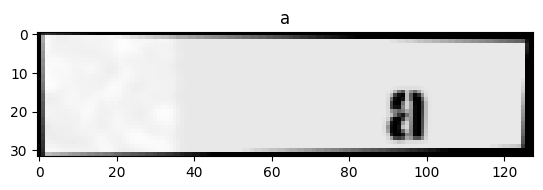

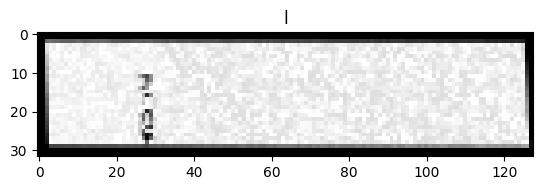

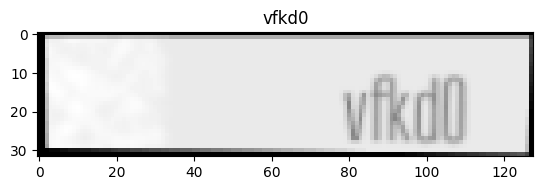

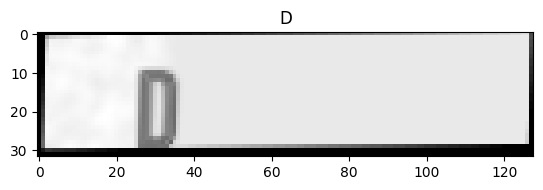

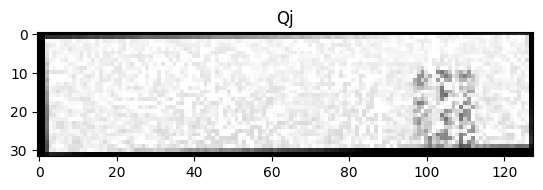

Epoch 1, Batch 0/40, Loss: 43.0244
Sample predictions: ['MGGG', 'l22G', 'GM2G2G26G9GMG']
Raw outputs (first 3): [[39 33 33 33 33 33 33 33  0 33  0  0  0  0 33 33 33 33 33 33 33 33 33 33
  33  0  0  0  0  0  0  0]
 [12 55  0 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 33 33 33 33 33
   0  0  0  0  0  0  0  0]
 [33 39 55 33 33 55 55 55 55 33 33 33 33 33 55 55 59 33 33 33 33 33 33 62
  62 62 33 39 33 33  0  0]]
Epoch 1, Batch 10/40, Loss: 5.0459
Sample predictions: ['<empty>', '<empty>', '<empty>']
Raw outputs (first 3): [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Epoch 1, Batch 20/40, Loss: 5.0023
Sample predictions: ['<empty>', '<empty>', '<empty>']
Raw outputs (first 3): [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 

In [19]:
if __name__ == "__main__":
    if not font_files:
        print("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
    else:
        create_synthetic_dataset(NUM_SAMPLES)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)

    for i in range(5):
        img, label, length = dataset[i]
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(''.join([idx_to_char.get(idx.item(), '') for idx in label[:length]]))
        plt.show()
    
    if len(dataset) == 0:
        print("Dataset is empty! Check labels.txt or image directory.")
    else:
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        model = OCRModel(num_chars=len(CHARSET)).to(device)
        criterion = nn.CTCLoss(blank=0, zero_infinity=True)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

        best_loss = float('inf')
        for epoch in range(EPOCHS):
            loss = train_model(model, train_loader, criterion, optimizer, device, epoch)
            print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss:.4f}")
            model.eval()
            with torch.no_grad():
                for imgs, _, _ in train_loader:
                    imgs = imgs.to(device)
                    outputs = model(imgs)
                    texts = decode_prediction(outputs, idx_to_char)
                    print("Predictions:", texts[:5])
                    break
            model.train()
            scheduler.step(loss)
            print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")
            if loss < best_loss:
                best_loss = loss
                torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_ocr_model.pth'))
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'final_ocr_model.pth'))

In [20]:
def zip_folder_with_shutil(source_folder, output_path):
    '''Function for zip dir data'''
    shutil.make_archive(output_path, 'zip', source_folder)

In [21]:
zip_folder_with_shutil('/kaggle/working/backgrounds', '/kaggle/working/backgrounds')
zip_folder_with_shutil('/kaggle/working/synthetic_data', '/kaggle/working/synthetic_data')